In [64]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [65]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.9.0


In [66]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


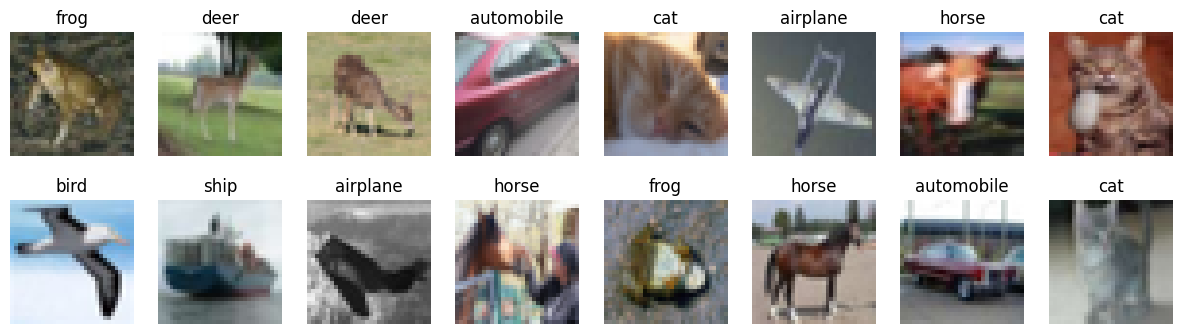

In [67]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [68]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [69]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [105]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network. 
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.

    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="leaky_relu", padding="SAME")) #Convolution layer
    model.add(MaxPooling2D(pool_size=(2, 2))) #first pooling layer
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="leaky_relu", padding="SAME"))
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="leaky_relu", padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="leaky_relu", padding="SAME"))
    model.add(Conv2D(filters=128, kernel_size = (3,3), activation="leaky_relu", padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(BatchNormalization())
 
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation="leaky_relu", padding="SAME"))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(BatchNormalization())

    model.add(Flatten()) #flatten
    model.add(Dense(256, activation='leaky_relu')) #fully connected layer
    model.add(Dropout(rate=0.5))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)  
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
   
    ### END STUDENT CODE ### 

    return model
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True) #data augmentation to improve generalisation

The first layer is a convolution layer with 32 filters and a kernel size of 5,5. Then a pooling layer is used to reduce the dimensionality of the map and summarise the information. Next, Batchnormalisation is used to stabilise the input by adjusting the mean and variance, helping to speed up training and improve the models performance.

These layers are then repeated three more times, with the 3rd and 4th convolution layers doubled. Doubling the layer can help the model learn more complex features, like shapes and textures, and reduces the risk of loosing spatial details from pooling. The number of filters increases with each layer. Lower levels are responsible for detecting more simple things like edges or texture, and higher levels add more complexity. Higher number of filters allows the network to learn more intricate patterns in the data. However, having a large number of filters takes longer to run, and also risks overfitting.

The kernel size starts at 5,5 in the first layer and then drops to 3,3 for the subsequent layers. A larger kerel size allows for a wider view of the input, and a smaller kernel size focuses more on smaller details. This allows the lower layers to focus on the general picture, and the higher layers to focus on smaller details. Like with increasing the number of filters, increasing the kernel size also takes longer to run.

The data is then flattened into a linear array for the next step. A fully connected (dense) layer is then used to connect each neuron to every other neuron, allowing the images to be classified based on the features identified by the previous layers. Then a dropout layer is used to help prevent overfitting by randomly setting a fraction of neurons to zero during training. This helps prevent the model from memorising the data. A higher rate makes the model more resilient to noise, but too high and the model may not learn effectively.

Finally, a second fully connected layer is used. The first fully connected layer has a larger kernel size than the last. Like before, a larger kernel size helps extract more complex features before classification. The final dense layer then has 10 kernels as this is the same as the number of classes in the dataset. The first dense layer learns the deep features, allowing the second to then map this to one of the classes in the dataset. 

The Adam optimiser is used as this automatically adapts the learning rate for each parameter, helping to speed up learning by converging quicker. Data augmentation is then added to help prevent overfitting. Data augmentation is a technique that allows the dataset to be artificially expanded by applying random transformations, such as rotations, zooming, and shifting, to the images in the dataset. This helps to prevent the model from memorising the training data and allows the model to train on a larger dataset. 

In [71]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 64 
EPOCHS = 50


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    datagen.flow(x_train, y_train),  # prepared data
    #batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.3328 - loss: 2.1061 - val_accuracy: 0.5375 - val_loss: 1.2868
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.5328 - loss: 1.3067 - val_accuracy: 0.5389 - val_loss: 1.3489
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.6254 - loss: 1.0654 - val_accuracy: 0.6046 - val_loss: 1.1295
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.6713 - loss: 0.9343 - val_accuracy: 0.6821 - val_loss: 0.8999
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.7082 - loss: 0.8426 - val_accuracy: 0.7225 - val_loss: 0.8004
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.7373 - loss: 0.7616 - val_accuracy: 0.7740 - val_loss: 0.6664
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.7549 - loss: 0.7090 - val_accuracy: 0.7241 - val_loss: 0.8707
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.7674 -

In [84]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


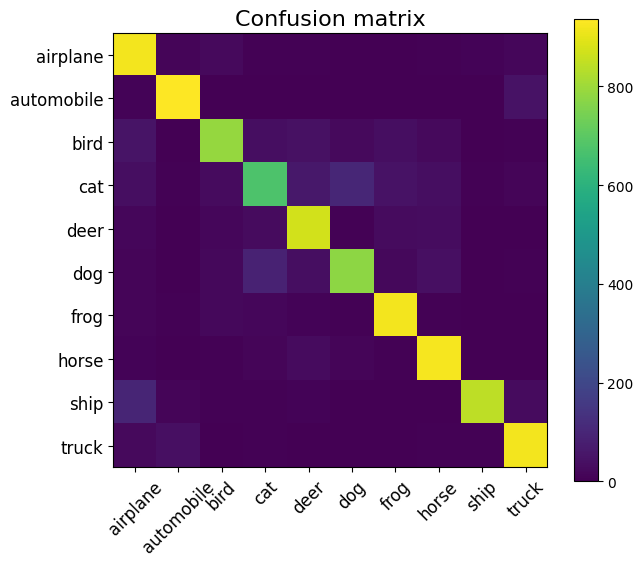

Test accuracy: 0.8578


In [85]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

Using 50 epochs, and a batch size of 64, I have managed to get a test accuracy of just over 85%. This suggests that the model is working fairly well. Looking at how it progressed through the epochs, it is clear that it is still increasing very slowly and hasn't completely platoed yet, but the amount of time that would have to go into training it further would only gain a small increase. 

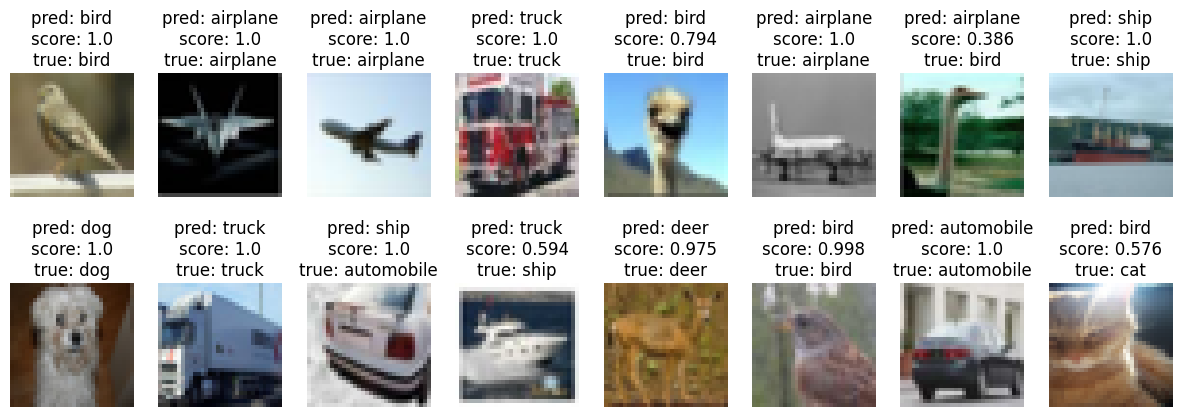

In [86]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

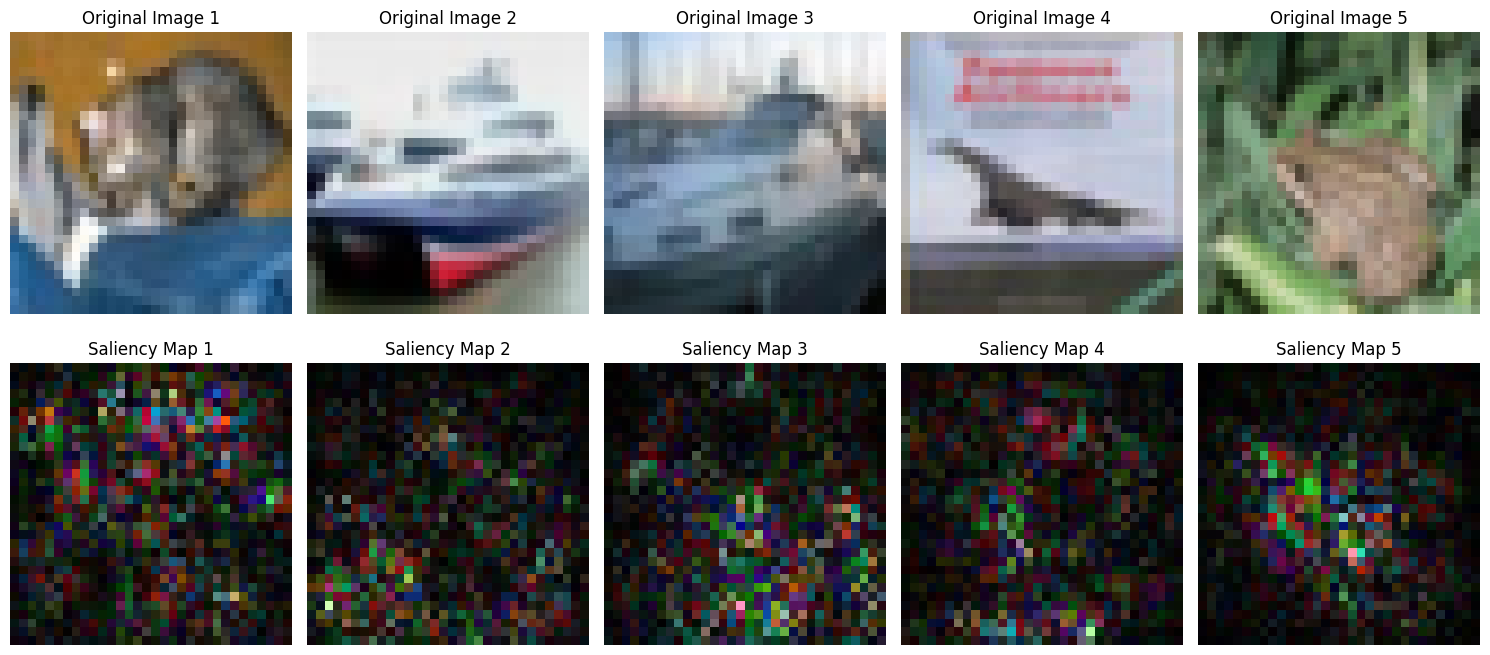

In [104]:
fig, ax = plt.subplots(2, 5, figsize=(15, 7)) 

for i in range(5):  
    image = x_test[i:i+1]  #selecting an image from the data set
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)  #track input image
        predictions = model(image_tensor)
        predicted_class = tf.argmax(predictions[0])  #predicted class
        loss = predictions[0, predicted_class]  #corresponding class score

    gradients = tape.gradient(loss, image_tensor)  #calculate the gradient of the ouput
    saliency = tf.abs(gradients)  #absolute values
    saliency = saliency.numpy().squeeze()  
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  #normalise values

    ax[0, i].imshow(image.squeeze()) #original image
    ax[0, i].set_title(f"Original Image {i+1}")
    ax[0, i].axis("off")

    ax[1, i].imshow(saliency)  #saliency map
    ax[1, i].set_title(f"Saliency Map {i+1}")
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()


This produces a saliency map for five of the images, allowing us to see what parts of the image the model looks at. This highlights the most important pixels in an image that influences the models prediction. The brighter the pixel, the more important.

An image is selected and is converted into a tensor. tf.GradientTape() then tracks the image gradients and computes the models prediction. The gradients of the prediction are then calculated by seeing how much each pixel in the image affects the predicted class score. This results in a gradient map, where high absolute values indicate important pixels. The absolute value of these gradients is then found, and then they are normalised. The saliency map can then be plotted alongside the original image so they can be compared to see why the model made the prediction. Using a for loop, this is then done for the first five images.

The pixels in the saliency maps are much brighter in areas with higher differences between pixels. In areas of high similarity, the pixels are mostly black. This suggests the model is more influenced by these differences as expected.

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


